In [1]:
import os
import numpy as np
import random
import cv2
import sklearn
import matplotlib.pyplot as plt
from PIL import Image
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras import regularizers
from keras.models import Sequential
from keras.optimizers import RMSprop , Adam
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense , Flatten , MaxPooling2D , Dropout , Activation , Conv2D
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score
from keras.models import load_model
import seaborn as sns
import keras
from keras.preprocessing.image import ImageDataGenerator
import efficientnet.keras as efn

In [2]:
training_data     = []
def Preprocessing(path , img):
    img_array = cv2.imread(os.path.join(path , img))
    image_from_array = Image.fromarray(img_array)
    sized_image = image_from_array.resize((150 , 150))
    training_data.append(np.array(sized_image))

In [3]:
men_path          = 'F:\\Projects\\Men And Women Classification\\Dataset\\men'
women_path        = 'F:\\Projects\\Men And Women Classification\\Dataset\\women'
img_size          = 150
labels            = []

for img in os.listdir(men_path):
    try:
        Preprocessing(men_path , img)
        labels.append(1)
    except Exception as e:
        pass
    
print('Finish men path')

for img in os.listdir(women_path):
    try:
        Preprocessing(women_path , img)
        labels.append(0)
    except Exception as e:
        pass
    
print('Finish women path')

Finish men path
Finish women path


In [4]:
training_data = np.array(training_data) / 255
np.shape(training_data)

(3311, 150, 150, 3)

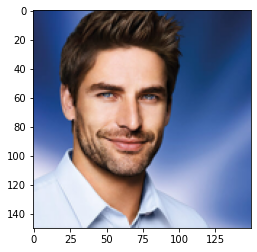

In [5]:
plt.imshow(cv2.cvtColor(training_data[9].astype('float32') , cv2.COLOR_BGR2RGB))

In [6]:
X = np.array(training_data)
y = np.array(labels)
print(X.shape)
print(y.shape)

(3311, 150, 150, 3)
(3311,)


In [7]:
datagen = ImageDataGenerator(horizontal_flip = True , rotation_range = 90 , shear_range = 0.3 , zoom_range = 0.3)
it = datagen.flow(X , batch_size = 1 , shuffle = False)

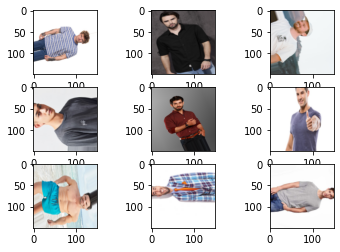

In [8]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0]
    # plot raw pixel data
    plt.imshow(cv2.cvtColor(image.astype('float32') , cv2.COLOR_BGR2RGB))
# show the figure
plt.show()

In [9]:
X_train , X_test , Y_train , Y_test = train_test_split(it , y , test_size = 0.2 , random_state = 42)
X_val , X_test , Y_val , Y_test = train_test_split(X_test , Y_test , test_size = 0.5 , random_state = 42)

In [10]:
X_train = np.array(X_train).reshape(-1 , img_size , img_size , 3)
X_test  = np.array(X_test).reshape(-1 , img_size , img_size , 3)
Y_train = np.array(Y_train)
Y_test  = np.array(Y_test)
X_val   = np.array(X_val).reshape(-1 , img_size , img_size , 3)
Y_val   = np.array(Y_val)

In [11]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(2648, 150, 150, 3)
(2648,)
(331, 150, 150, 3)
(331,)
(332, 150, 150, 3)
(332,)


In [12]:
efn_model = efn.EfficientNetB0(input_shape = (img_size, img_size, 3), include_top = False, weights = 'imagenet')
for layer in efn_model.layers:
    layer.trainable = False
    
model = Sequential(efn_model)
model.add(Flatten())
model.add(Dense(128 , activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Functional) (None, 5, 5, 1280)        4049564   
_________________________________________________________________
flatten (Flatten)            (None, 32000)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4096128   
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 8,145,821
Trainable params: 4,096,257
Non-trainable params: 4,049,564
_________________________________________________________________


In [13]:
model.compile(loss = 'binary_crossentropy' , optimizer = Adam(lr = 0.001) , metrics = ['accuracy'])

In [14]:
history = model.fit(X_train , Y_train , batch_size = 48 , epochs = 30 , validation_data = (X_val , Y_val))

Epoch 1/30
56/56 [==============================] - 113s 2s/step - loss: 0.6039 - accuracy: 0.6964 - val_loss: 0.4807 - val_accuracy: 0.7946
Epoch 2/30
56/56 [==============================] - 103s 2s/step - loss: 0.3694 - accuracy: 0.8327 - val_loss: 0.5119 - val_accuracy: 0.7432
Epoch 3/30
56/56 [==============================] - 102s 2s/step - loss: 0.2635 - accuracy: 0.8912 - val_loss: 0.4814 - val_accuracy: 0.7795
Epoch 4/30
56/56 [==============================] - 106s 2s/step - loss: 0.1964 - accuracy: 0.9305 - val_loss: 0.4837 - val_accuracy: 0.7795
Epoch 5/30
56/56 [==============================] - 103s 2s/step - loss: 0.1603 - accuracy: 0.9430 - val_loss: 0.4859 - val_accuracy: 0.7946
Epoch 6/30
56/56 [==============================] - 97s 2s/step - loss: 0.1183 - accuracy: 0.9683 - val_loss: 0.5072 - val_accuracy: 0.7885
Epoch 7/30
56/56 [==============================] - 98s 2s/step - loss: 0.0983 - accuracy: 0.9694 - val_loss: 0.5003 - val_accuracy: 0.7915
Epoch 8/30
56/5

In [15]:
predictions = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


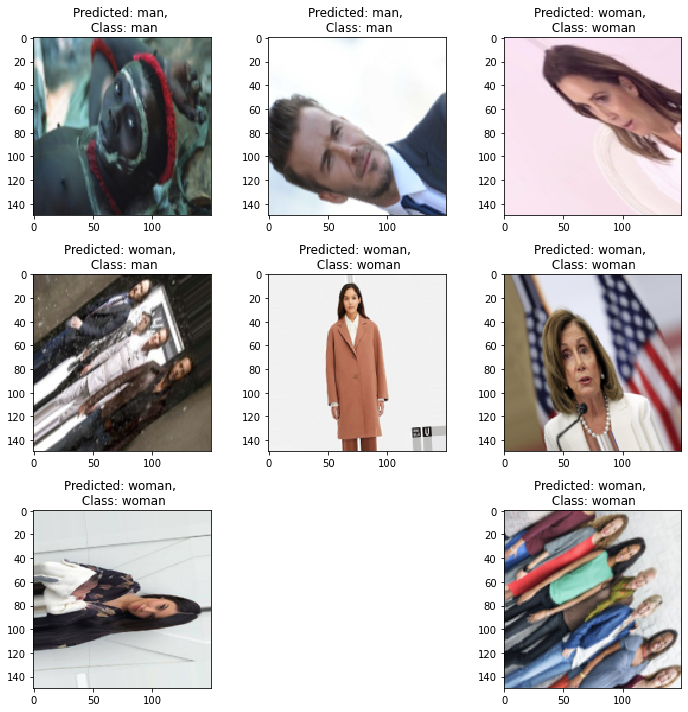

In [16]:
random_indices = [random.randint(0 , len(X_test)) for i in range(9)]
plt.figure(figsize=(10,10))
for i, index in enumerate(random_indices):
    pred = predictions[index]
    pred = 'man' if pred==1 else 'woman'
    actual = 'man' if Y_test[index]==1 else 'woman'
    plt.subplot(3 , 3 , i + 1)
    plt.imshow(cv2.cvtColor(X_test[index].astype('float32') , cv2.COLOR_BGR2RGB), interpolation='none')
    plt.title(f"Predicted: {pred}, \n Class: {actual}")
    plt.tight_layout()

In [17]:
confusion_matrix(Y_test , predictions)

array([[150,  34],
       [ 44, 104]], dtype=int64)

In [18]:
print(classification_report(Y_test , predictions))

              precision    recall  f1-score   support

           0       0.77      0.82      0.79       184
           1       0.75      0.70      0.73       148

    accuracy                           0.77       332
   macro avg       0.76      0.76      0.76       332
weighted avg       0.76      0.77      0.76       332



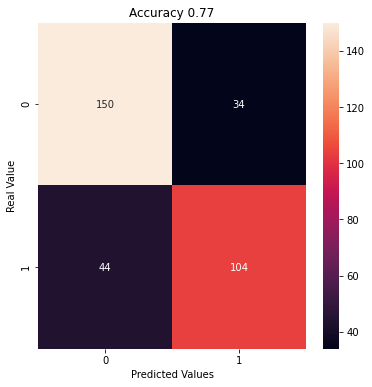

In [19]:
Confusion_Mtrx = confusion_matrix(Y_test , predictions)
true_positive , false_positive, false_negative, true_negative = Confusion_Mtrx.ravel()

plt.figure(figsize=(6,6))
sns.heatmap(Confusion_Mtrx, annot=True, fmt=".0f");
plt.ylabel('Real Value');
plt.xlabel('Predicted Values');
plt.title('Accuracy {0:.2f}'.format(accuracy_score(Y_test , predictions)));

In [20]:
accuracy = model.evaluate(X_test , Y_test, verbose = 1)
print(accuracy)

11/11 [==============================] - 10s 914ms/step - loss: 0.8092 - accuracy: 0.7651
[0.8091606497764587, 0.7650602459907532]


In [21]:
#model.save('men_women_classification.h5')